# CSE 252B: Computer Vision II, Winter 2019 – Assignment 4
### Instructor: Ben Ochoa
### Due: Wednesday, March 6, 2019, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains both math and programming problems.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX. Remember to show work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. Ask the instructor if in doubt.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

In [1]:
import pdb

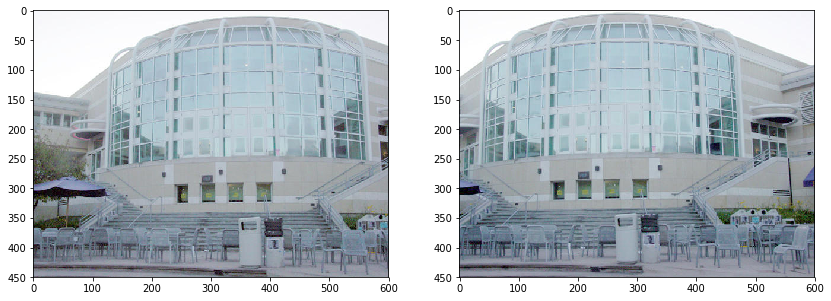

In [2]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

# open the input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()

## Problem 1 (Programming): Feature detection (20 points)
Download input data from the course website. The file price_center20.JPG
contains image 1 and the file price_center21.JPG contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
around 600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

#### Report your final values for:
 * the size of the feature detection window (i.e. the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value 
 * the size of the local nonmaximum suppression window 
 * the resulting number of features detected (i.e. corners) in each image.

#### Display figures for:
 * original images with detected features


In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def AddandAverage(i, j, width, I):
    return np.average(I[i - width : i + width + 1, j - width : j + width + 1])

In [4]:
def ImageGradient(I, w, t):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    #
    # outputs:
    # N is the 2x2xmxn gradient matrix
    # b in the 2x1xmxn vector used in the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    
    m,n = I.shape[:2]
    N = np.zeros((2,2,m,n))
    b = np.zeros((2,1,m,n))
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))
        
    ####Compute Gradient
    Ix2, Iy2, IxIy = np.zeros(I.shape), np.zeros(I.shape), np.zeros(I.shape)
    Ixb2, Iyb2 = np.zeros(I.shape), np.zeros(I.shape)
    gradFilt = np.array([-1, 8, 0, -8, 1]) / 12
    
    
    for i in range(2, I.shape[1] - 2): ##x
        for j in range(2, I.shape[0] - 2): ##y
            ix = np.dot(I[j, i - 2 : i + 3], gradFilt)
            iy = np.dot(I[j - 2 : j + 3, i], gradFilt.T)
            Ix2[j, i], Iy2[j, i], IxIy[j, i] = ix **2, iy **2, ix * iy
            Ixb2[j, i], Iyb2[j, i] = Ix2[j, i] * i + IxIy[j, i] * j, Iy2[j, i] * j + IxIy[j, i] * i
    
    width = (w - 1) // 2
    for i in range(width, m - width):
        for j in range(width, n - width):
            ix2, iy2, ixiy = AddandAverage(i, j, width, Ix2), AddandAverage(i, j, width, Iy2), AddandAverage(i, j, width, IxIy)
            ixb2, iyb2 = AddandAverage(i, j, width, Ixb2), AddandAverage(i, j, width, Iyb2)
            N[:, :, i, j] = np.matrix([[ix2, ixiy], [ixiy, iy2]])
            b[:, :, i, j] = np.matrix([[ixb2], [iyb2]])
            w, v = np.linalg.eig(N[:, :, i, j])
            J0[i, j] = np.min(w)
            if J0[i, j] > t:
                J1[i, j] = J0[i, j]
    
    return N, b, J0, J1

def NMS(J, w_nms):
    # Apply nonmaximum supression to J using window w
    # For any window in J, the result should only contain 1 nonzero value
    # In the case of multiple identical maxima in the same window,
    # the tie may be broken arbitrarily
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
    
    J2 = J.copy()
    Jmax = np.zeros(J2.shape)
    width = (w_nms - 1) // 2
    for i in range(width, J.shape[0]):
        for j in range(width, J.shape[1]):
            Jmax[i, j] = np.max(J2[i - width : i + width + 1, j - width : j + width + 1])
    
    for i in range(width, J.shape[0]):
        for j in range(width, J.shape[1]):
            if J[i, j] < Jmax[i, j]:
                J2[i, j] = 0
            else:
                J2[i, j] = Jmax[i, j]
    
    return J2
  
    
def ForstnerCornerDetector(J, N, b):
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # J is the NMS image
    # N is the 2x2xmxn gradient matrix
    # b is the 2x1xmxn vector computed in the image_gradient function
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC list of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    
    pts = np.zeros((2, 1))
    C = 0
    for i in range(0, J.shape[0]):
        for j in range(0, J.shape[1]):
            if J[i, j] != 0:
                C += 1
                pts = np.hstack((pts, np.dot(np.linalg.inv(N[:, :, i, j]), b[:, :, i, j])))
      
    return C, pts[:, 1:]


# feature detection
def RunFeatureDetection(I, w, t, w_nms):
    N, b, J0, J1 = ImageGradient(I, w, t)
    J2 = NMS(J1, w_nms)
    C, pts = ForstnerCornerDetector(J2, N, b)
    return C, pts, J0, J1, J2


took 62.314660 secs


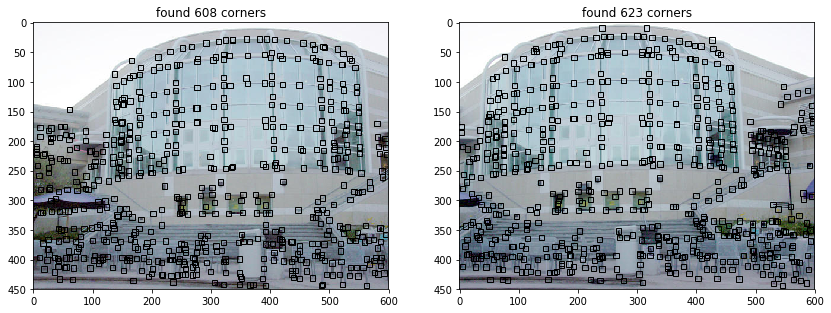

In [5]:
# input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# parameters to tune
w = 9
t = 0.00048
w_nms = 7

tic = time.time()

# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = RunFeatureDetection(rgb2gray(I1), w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = RunFeatureDetection(rgb2gray(I2), w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1,2,1)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('found %d corners'%C1)

ax = plt.subplot(1,2,2)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('found %d corners'%C2)

plt.show()

#### Final values for parameters
* w =
* t =
* w_nms =
* C1 = 
* C2 = 

## Problem 2 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that around 200 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold 
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e. matched features)

#### Display figures for:
* pair of images, where the matched features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image



In [6]:
import numpy.ma as ma
from math import sqrt

def NCC(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    
    """your code here"""
    
    scores = np.zeros((pts1.shape[1], pts2.shape[1]))
    R = (w - 1) // 2
    
    pts1 = pts1.astype(int)
    pts2 = pts2.astype(int)
    
    for i in range(0, scores.shape[0]):
        if pts1[1, i] < R or pts1[1, i] >= I1.shape[0] - R or pts1[0, i] < R or pts1[0, i] >= I1.shape[1] - R:
            continue
        for j in range(0, scores.shape[1]):
            if pts2[1, j] < R or pts2[1, j] >= I2.shape[0] - R or pts2[0, j] < R or pts2[0, j] >= I2.shape[1] - R:
                continue
            w1 = I1[pts1[1, i] - R : pts1[1, i] + R + 1, pts1[0, i] - R : pts1[0, i] + R + 1]
            w2 = I2[pts2[1, j] - R : pts2[1, j] + R + 1, pts2[0, j] - R : pts2[0, j] + R + 1]
            mean1, mean2 = np.mean(w1), np.mean(w2)   
            matching_score = 0
            denom1, denom2 = 0, 0
            
            for r in range(0, w):
                for c in range(0, w):
                    matching_score += (w1[r, c] - mean1) * (w2[r, c] - mean2)
                    denom1, denom2 = denom1 + (w1[r, c] - mean1) ** 2, denom2 + (w2[r, c] - mean2) ** 2
            scores[i, j] = (matching_score / sqrt(denom1 * denom2))
    
    return scores



def Match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # output:
    # list of the feature coordinates in image 1 and image 2 
    
    """your code here"""
    #inds = np.vstack((np.random.choice(pts1.shape[1],200,replace=False), 
      #                np.random.choice(pts1.shape[1],200,replace=False)))
    
    mask = ma.array(scores)
    inds = np.zeros((2, 1))
    
    while np.max(mask) > t:
        maximum = np.max(mask)
        index = np.unravel_index(np.argmax(mask), scores.shape)
        #print(maximum, index, np.argmax(mask), scores.shape)
        mask[index] = ma.masked
        nextbest = max(mask[index[0],:].max(), mask[:, index[1]].max())
        if (1 - maximum) < ((1 - nextbest) * d):
            inds = np.hstack((inds, np.array([[index[0]], [index[1]]])))
        mask[index[0], :] = ma.masked
        mask[:, index[1]] = ma.masked
    
    #print(mask)
    inds = inds[:, 1:]
    return inds.astype(int)


def RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p=0):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = NCC(I1, I2, pts1, pts2, w, p)
    inds = Match(scores, t, d) 
    return inds



took 82.160251 secs


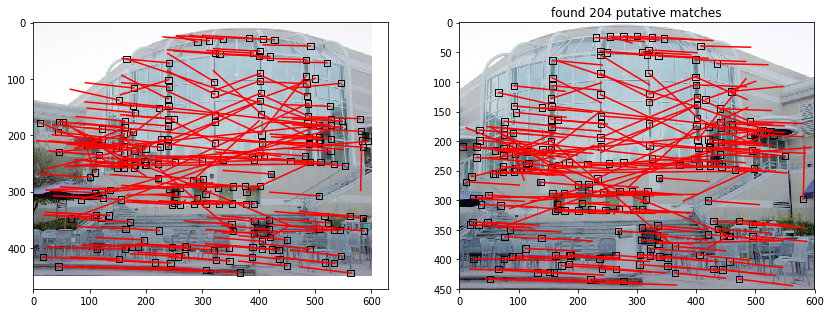

unique points in image 1: 204
unique points in image 2: 204


In [7]:
# parameters to tune
w = 11
t = 0.83
d = 2.6
p = np.inf

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = RunFeatureMatching(rgb2gray(I1), rgb2gray(I2), pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
match1 = pts1[:,inds[0,:]]
match2 = pts2[:,inds[1,:]]

# # display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d putative matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

In [8]:
match1[:, :10], match2[:, :10]

(array([[239.79831407, 239.55035443, 260.54355398, 488.55624534,
         109.20990894, 421.68002851, 581.71102923, 239.23703409,
         375.65849628, 121.38334305],
        [148.31813171, 183.25649948, 293.54185514, 202.17011712,
         301.77321555, 268.32677564, 192.73938723, 170.18703314,
         290.4666181 , 206.13983553]]),
 array([[154.8149314 , 155.91781132, 176.68196747, 401.71527156,
          22.47219189, 337.19601826, 491.32624852, 155.26406693,
         291.43815304,  33.51121823],
        [213.17676045, 176.49319131, 287.84513467, 161.04179858,
         296.77891735, 262.16608395, 188.38949925, 163.26190598,
         284.29467661, 198.63975215]]))

#### Final values for parameters
* w =
* t =
* d =
* p =
* num_matches = 

## Problem 3 (Programming): Outlier Rejection (15 points)
The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 4-point algorithm (as described in
lecture) to estimate the planar projective transformation from the 2D points in
image 1 to the 2D points in image 2. Calculate the (squared) Sampson error as a
first order approximation to the geometric error.

hint: this problem has codimension 2

#### Report your values for:
 * the probability $p$ that as least one of the random samples does not contain any outliers
 * the probability $\alpha$ that a given point is an inlier
 * the resulting number of inliers
 * the number of attempts to find the consensus set
 * the tolerance for inliers
 * the cost threshold
 
#### Display figures for:
* pair of images, where the inlier features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image


In [9]:
def Homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))


def Dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

In [10]:
def fourPointAlgorithm(x):
    x123 = x[:, :3]
    x4 = x[:, 3].reshape((3, 1))
    lam = np.linalg.inv(x123) @ x4
    
    x1 = (x[:, 0] * lam[0]).reshape((3, 1))
    x2 = (x[:, 1] * lam[1]).reshape((3, 1))
    x3 = (x[:, 2] * lam[2]).reshape((3, 1))
    H_inv = np.hstack((np.hstack((x1, x2)), x3))
    return H_inv

In [11]:
def sampsonError(x, x_p, H):
    x = Dehomogenize(x)
    x_p = Dehomogenize(x_p)
    
    error = []
    h11, h12, h13, h21, h22, h23, h31, h32, h33 = \
        H[0, 0], H[0, 1], H[0, 2], H[1, 0], H[1, 1], H[1, 2], H[2, 0], H[2, 1], H[2, 2]
    
    for i in range(x_p.shape[1]):
        xi, yi = x[0, i], x[1, i]
        xi_p, yi_p = x_p[0, i], x_p[1, i]
        
        term2 = xi * h31 + yi * h32 + h33
        E = np.array([[-(xi * h21 + yi * h22 + h23) + yi_p * term2],
                      [(xi * h11 + yi * h12 + h13) - xi_p * term2]])
    
        
        J = np.array([[-h21 + yi_p * h31, -h22 + yi_p * h32, 0, term2],
                      [h11 - xi_p * h31, h12 - xi_p * h32, -(term2), 0]])
        
        error.append(E.T @ np.linalg.inv(J @ J.T) @ E) 
        
    return np.asarray(error)

In [12]:
def compute_cost(error, tol):
    consensus_cost = 0
    inlier_count = 0
    for i in range(error.shape[0]):
        if error[i] > tol:
            consensus_cost += tol
        else:
            consensus_cost += error[i]
            inlier_count += 1
    return consensus_cost, inlier_count

In [13]:
from scipy.stats import chi2

def calculate_tolerance(alpha):
    lam, var, cod = alpha, 1, 2
    t = chi2.ppf(lam, cod) * var
    return t

def MSAC(pts1, pts2, thresh, tol, p):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance 
    #    p - probability that as least one of the random samples does not contain any outliers   
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - planar projective transformation matrix H
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set
    
    #print(pts1.shape)
    #print(pts2.shape)
        
    total_point_num = pts1.shape[1]
    pts1_homo, pts2_homo = Homogenize(pts1), Homogenize(pts2)

    trials = 0
    max_trials = np.inf
    consensus_min_cost = np.inf
    consensus_min_cost_model = np.zeros((3,3))
    inliers = []
    
    while trials < max_trials and consensus_min_cost > thresh:
        idx = np.random.choice(pts1.shape[1], 4, replace = False)
        #idx = [0, 1, 2, 3]
        pts1_homo_sampled, pts2_homo_sampled = pts1_homo[:, idx], pts2_homo[:, idx]
        H1_inv = fourPointAlgorithm(pts1_homo_sampled)
        H2_inv = fourPointAlgorithm(pts2_homo_sampled)
        H12 = H2_inv @ np.linalg.inv(H1_inv)
        #print("H12", H12)
        #print("error", sampsonError(pts1_homo[:, 4].reshape((-1, 1)), pts2_homo[:, 4].reshape((-1, 1)), H12))
        #print("1", pts1_homo_sampled)
        #print("2", pts2_homo_sampled)
        #print("check", H12 @ pts1_homo_sampled)
        

        ###### compute error for each set of error
        #print("pts1_homoe")
        #print("out", pts1_homo.shape, pts2_homo.shape)
        error = sampsonError(pts1_homo, pts2_homo, H12)
        #print("error", error)
        consensus_cost, inlier_count = compute_cost(error, tol)
        #print("error", error)
        #print("cost", consensus_cost)
        #print("count", inlier_count)
        
                    
        ###### determine if this is the model we want
        if consensus_cost < consensus_min_cost:
            consensus_min_cost = consensus_cost
            consensus_min_cost_model = H12
            
            ###### adaptive maxtrials
            w = inlier_count / total_point_num
            max_trials = np.log(1 - p) / np.log(1 - w ** 3)
        
        trials += 1
        
    #### find set of inliers
    error = sampsonError(pts1_homo, pts2_homo, consensus_min_cost_model)
    
    for i in range(total_point_num):
        if error[i] <= tol:
            inliers.append(i)
            
    return consensus_min_cost, consensus_min_cost_model, inliers, trials


# MSAC parameters 
thresh = 100
alpha = 0.95
tol = calculate_tolerance(alpha)
p = 0.99


tic=time.time()

cost_MSAC, H_MSAC, inliers, trials = MSAC(match1, match2, thresh, tol, p)

# choose just the inliers
x1 = match1[:,inliers]
x2 = match2[:,inliers]
outliers = np.setdiff1d(np.arange(pts1.shape[1]),inliers)

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost=%.9f'%cost_MSAC)
print('H_MSAC = ')
print(H_MSAC)

# display the figures
"""your code here"""

took 0.069270 secs
12 iterations
inlier count:  142
inliers:  [1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 57, 59, 60, 62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 117, 118, 119, 120, 123, 125, 126, 127, 128, 129, 131, 132, 133, 135, 136, 138, 139, 140, 141, 143, 144, 147, 148, 149, 156, 157, 158, 159, 160, 161, 164, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 182, 184, 187, 188, 191, 192, 194, 197, 198, 203]
MSAC Cost=440.686937115
H_MSAC = 
[[ 1.00500035e+00 -6.71475385e-03 -8.81297910e+01]
 [ 3.19614728e-02  9.78630608e-01 -1.71699063e+01]
 [ 1.23465997e-04  8.71879226e-07  9.35608859e-01]]


'your code here'

#### Final values for parameters
* $p$ =
* $\alpha$ =
* tolerance = 
* threshold = 
* num_inliers =
* num_attempts = 

## Problem 4 (Programming): Linear Estimate (15 points)
  Estimate the planar projective transformation $\boldsymbol{H}_\text{DLT}$
  from the resulting set of inlier correspondences using the direct
  linear transformation (DLT) algorithm (with data normalization).
  You must express $\boldsymbol{x}'_i = \boldsymbol{H} \boldsymbol{x}_i$ as
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$ (not
  $\boldsymbol{x}'_i \times \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$), where
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{x}'_i = \boldsymbol{0}$, when forming the
  solution. Return $\boldsymbol{H}_\text{DLT}$, scaled such that
  $||\boldsymbol{H}_\text{DLT}||_\text{Fro} = 1$

In [14]:
def Normalize(pts):
    # data normalization of n dimensional pts
    #
    # Input:
    #    pts - is in inhomogeneous coordinates
    # Outputs:
    #    pts - data normalized points
    #    T - corresponding transformation matrix
    
    dim = pts.shape[0]
    mean = np.mean(pts, axis = 1).reshape((dim, 1))
    var = np.var(pts, axis = 1)
    totalVar = np.sum(var)
    s = np.sqrt(dim / totalVar)
    
    #construct T
    T = np.hstack((np.identity(dim) * s, mean * s * -1))
    T = np.vstack((T, np.zeros(dim + 1)))
    T[-1, -1] = 1
    
    pts = Homogenize(pts)
    pts = np.dot(T, pts)
    
    return pts, T

In [15]:
def leftNullofVector(X):
    X = X.reshape((X.shape[0], 1))
    e = np.zeros(X.shape)
    e[0, 0] = 1
    #print("shape", X.shape, e.shape)
    
    v = X + np.sign(X[0, 0]) * np.linalg.norm(X) * e
    Hv = np.identity(X.shape[0]) - 2 * (v @ v.T) / (v.T @ v)
    
    return Hv[1:, :]

In [16]:
def SampsonCorrection(x, x_prime, H):
    #print("----------------- Sampson Correction ----------------- ")
    error = []
    h11, h12, h13, h21, h22, h23, h31, h32, h33 = \
        H[0, 0], H[0, 1], H[0, 2], H[1, 0], H[1, 1], H[1, 2], H[2, 0], H[2, 1], H[2, 2]
    
    x_scene = np.hstack((x.T, x_prime.T))
    x_scene = x_scene.T
    print(x_scene.shape)
    
    for i in range(x_scene.shape[1]):
        xi, yi = x[0, i], x[1, i]
        xi_p, yi_p = x_prime[0, i], x_prime[1, i]
        #print("check", xi, yi)
        #print(xi)
        
        term2 = xi * h31 + yi * h32 + h33
        E = np.array([[-(xi * h21 + yi * h22 + h23) + yi_p * term2],
                      [(xi * h11 + yi * h12 + h13) - xi_p * term2]])
        #print("E", E)
        
        J = np.array([[-h21 + yi_p * h31, -h22 + yi_p * h32, 0, xi * h31 + yi * h32 + h33],
                      [h11 - xi_p * h31, h12 - xi_p * h32, -(xi * h31 + yi * h32 + h33), 0]])
        #print("J", J)
        lam = np.linalg.inv(J @ J.T) @ -E
        #print("lam", lam)
        eps = J.T @ lam
        #print("eps", eps)
        #print(x_scene[:, i])
        #print(x_scene[:, i] + eps.reshape(-1))
        x_scene[:, i] = x_scene[:, i] + eps.reshape(-1)
    #print("----------------- Sampson Correction ----------------- ")
    return x_scene[:2, :]

def ConstructMeasVect(x_scene, h):
    tmp_x = x_scene.reshape((1, -1), order='F')
    return np.hstack((h.T, tmp_x))


def ComputeCost(E, E_p, invcov, invcov_p):
    cost = 0
    for i in range(E.shape[1]):
        cost += E[:, i].reshape((-1, 1)).T @ invcov @ E[:, i].reshape((-1, 1)) + E_p[:, i].reshape((-1, 1)).T @ invcov_p @ E_p[:, i].reshape((-1, 1))
    return cost

In [23]:
def DLT(x1, x2, normalize=True):
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 1
    #    normalize - if True, apply data normalization to x1 and x2
    #
    # Outputs:
    #    H - the DLT estimate of the planar projective transformation   
    #    cost - linear estimate cost
    
    """your code here"""
    tmp1, tmp2 = x1, x2
    
    # data normalization
    if normalize:
        x1, T = Normalize(x1)
        x2, T_2 = Normalize(x2)
        print("T", T)
        print("T_2", T_2)
    else:
        x1 = Homogenize(x1)
        x2 = Homogenize(x2)
        

    
    A = np.zeros((1, 9))
    for col in range(0, x1.shape[1]):
        xNull = leftNullofVector(x2[:, col])
        A = np.vstack((A, np.kron(xNull, x1[:, col].T)))
    
    A = A[1:]
    
    u, s, vt = np.linalg.svd(A)
    H = vt[-1, :]
    H = np.reshape(H, (3, 3))
    
    if normalize:
        invcov = np.linalg.inv(np.identity(2) * np.square(T[0, 0]))
        invcov_p = np.linalg.inv(np.identity(2) * np.square(T_2[0, 0]))
    else:
        invcov = np.eye(2)
        invcov_p = np.eye(2)
        
    x_scene = Homogenize(SampsonCorrection(Dehomogenize(x1), Dehomogenize(x2), H))
    E = Dehomogenize(x1) - Dehomogenize(np.identity(3) @ x_scene)
    E_p = Dehomogenize(x2) - Dehomogenize(H @ x_scene)
    cost = ComputeCost(E, E_p, invcov, invcov_p)
    
    
    # data denormalize
    if normalize:
        H = np.linalg.inv(T_2) @ H @ T
    H = H / np.linalg.norm(H)
    
    
    
    
    
    #cost = sampsonError(Homogenize(x1), Homogenize(x2), H)
    print(H)
    
    return H, cost

i = [1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13]
x1 = match1[:, i]
x2 = match2[:, i]
print("x1", x1)
print("x2", x2)


# compute the linear estimate without data normalization
print ('Running DLT without data normalization')
time_start=time.time()
H_DLT, cost = DLT(x1, x2, normalize=False)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)


# compute the linear estimate with data normalization
print ('Running DLT with data normalization')
time_start=time.time()
H_DLT, cost = DLT(x1, x2, normalize=True)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)

x1 [[239.55035443 260.54355398 109.20990894 421.68002851 581.71102923
  239.23703409 375.65849628 121.38334305 388.61595687 160.9513491
  517.19950225]
 [183.25649948 293.54185514 301.77321555 268.32677564 192.73938723
  170.18703314 290.4666181  206.13983553 415.1007892  218.35155601
  425.68378038]]
x2 [[155.91781132 176.68196747  22.47219189 337.19601826 491.32624852
  155.26406693 291.43815304  33.51121823 304.56198231  74.63449444
  429.27904711]
 [176.49319131 287.84513467 296.77891735 262.16608395 188.38949925
  163.26190598 284.29467661 198.63975215 408.50678269 211.6605196
  415.90558471]]
Running DLT without data normalization
(4, 11)
[[ 1.07424047e-02  1.21661448e-04 -9.82660195e-01]
 [ 2.71930862e-04  1.06462107e-02 -1.84523794e-01]
 [ 1.06445520e-06  4.28055024e-07  1.00538881e-02]]
took 0.017833 secs
Cost=1.365785001
Running DLT with data normalization
T [[ 0.0081933   0.         -2.54419842]
 [ 0.          0.0081933  -2.208889  ]
 [ 0.          0.          1.        ]]
T

In [24]:
# display your H_DLT, scaled with its frobenius norm
print('H_DLT = ', H_DLT)


H_DLT =  [[ 1.10461257e-02  2.41267696e-05 -9.86062319e-01]
 [ 2.76198718e-04  1.08454176e-02 -1.65326759e-01]
 [ 1.10341245e-06  1.22004212e-07  1.04139185e-02]]


## Problem 5 (Programming): Nonlinear Estimate (45 points) 
 Use $\boldsymbol{H}_\text{DLT}$ and the Sampson corrected points (in image 1) as an initial estimate to an iterative estimation method,
  specifically the sparse Levenberg-Marquardt algorithm, to
  determine the Maximum Likelihood estimate of the planar projective
  transformation that minimizes the reprojection error.  You must
  parameterize the planar projective transformation matrix and the
  homogeneous 2D scene points that are being adjusted using the
  parameterization of homogeneous vectors (see section A6.9.2 (page 624) of the textbook, and the corrections and errata).
  
  Report the initial cost (i.e. cost at iteration 0) and the cost at the end
  of each successive iteration. Show the numerical values for the final 
  estimate of the planar projective transformation matrix $\boldsymbol{H}_\text{LM}$, scaled
  such that $||\boldsymbol{H}_\text{LM}||_\text{Fro} = 1$.

In [25]:
def Parameterize(P, isH = True):
    # wrapper function to interface with LM
    # takes all optimization variables and parameterizes all of them
    # in this case it is just P, but in future assignments it will
    # be more useful
    if isH:
        return ParameterizeHomog(P.reshape(-1,1))
    else:
        result = np.zeros((P.shape[0] - 1, 1))
        for i in range(P.shape[1]):
            result = np.hstack((result, ParameterizeHomog(P[:, i]).reshape(-1, 1)))
        return result[:, 1:]


def Deparameterize(p, isH = True):
    # Deparameterize all optimization variables
    if isH:
        return DeParameterizeHomog(p).reshape(3,3)
    else:
        result = np.zeros((p.shape[0] + 1, 1))
        for i in range(p.shape[1]):
            result = np.hstack((result, DeParameterizeHomog(p[:, i]).reshape(-1, 1)))
        return result[:, 1:]
    


def ParameterizeHomog(V):
    # Given a homogeneous vector V return its minimal parameterization
    """your code here"""
    #print("-------Parameterize------")
    v = V / np.linalg.norm(V) 
    a, b = v[0], v[1:]
    v_hat = (2 / Sinc(np.arccos(a))) * b

    norm = np.linalg.norm(v_hat)
    if norm > np.pi:
        v_hat *= 1 - ((2 * np.pi) / norm) * np.ceil((norm - np.pi) /(2 * np.pi))
    #print("---------Parameterize end----------")
    #print("v_hat", v_hat.shape)
    return v_hat


def DeParameterizeHomog(v):
    # Given a parameterized homogeneous vector return its deparameterization
    """your code here"""
    #print("-------DeParameterize------")
    norm = np.linalg.norm(v)
    v_bar = np.zeros((v.shape[0] + 1, 1))
    v_bar = np.array([np.cos(norm / 2)]).reshape((-1, 1))
    v_bar = np.vstack((v_bar, ((Sinc(norm / 2) / 2)* v).reshape((-1, 1))))
    v_bar /= np.linalg.norm(v_bar)
    #print("-------DeParameterize end------")
    return v_bar

In [26]:
def ComputeAB(H_p, x_scene):
    A_p, B, B_p = [], [], []
    x_hat = Dehomogenize(np.identity(3) @ x_scene)  ## I @ x_scene
    x_hat_p = Dehomogenize(H_p @ x_scene)             ## H @ x_scene
    #print("x_scene", x_scene.shape)
    for i in range(x_scene.shape[1]):
        A_p.append(ComputeA_p(x_scene[:, i], x_hat_p[:, i], H_p))
        B.append(ComputeB(x_scene[:, i], x_hat[:, i], np.identity(3)))
        B_p.append(ComputeB(x_scene[:, i], x_hat_p[:, i], H_p))
    return A_p, B, B_p  

def ComputeA_p(x_scene, x_hat_p, H_p):
    x_scene = x_scene.reshape((-1, 1))
    #print("onex_scne", x_scene.shape)
    w_p = H_p[2, :] @ x_scene
    term1 = dxhat_dh(x_scene, x_hat_p, w_p)
    term2 = dhbar_dh(H_p)
    return dxhat_dh(x_scene, x_hat_p, w_p) @ dhbar_dh(H_p)

def ComputeB(x_scene, x_hat, H_p):
    x_scene = x_scene.reshape((3, 1))
    w_p = H_p[2, :] @ x_scene
    #print("term1:", dxhat_dxscene(x_hat, H, w_p ).shape)
    #print("term2:", dhbar_dh(x_scene, False).shape)
    term1 = dxhat_dxscene(x_hat, H_p, w_p)
    term2 = dhbar_dh(x_scene, False)
    #pdb.set_trace()
    return dxhat_dxscene(x_hat, H_p, w_p) @ dhbar_dh(x_scene, False)

def dxhat_dh(x_scene, x_hat_p, w_p):
    zero = np.zeros((3, 1))
    #print("x.T", x_scene.T.shape)
    #print("zero.T", zero.T.shape)
    #print("last", x_hat_p[0])
    row1 = np.hstack((x_scene.T, zero.T, -x_hat_p[0] * x_scene.T))
    row2 = np.hstack((zero.T, x_scene.T, -x_hat_p[1] * x_scene.T))
    
    return (1 / w_p) * np.vstack((row1, row2))

def dxhat_dxscene(x_hat, H, w_p):
    array = np.vstack(([H[0, :] - x_hat[0] * H[2, :]],[H[1, :] - x_hat[1] * H[2, :]]))
    #print("sppo", array.shape)
    return (1 / w_p) * array

def dhbar_dh(H, isH = True):
    h = Parameterize(H, isH)
    #print("isH", isH)
    #print(H)
    #print(H.shape)
    #print(h.shape)
    #print(Dehomogenize(Deparameterize(h, isH)))
    norm = np.linalg.norm(h)
    h_bar = H.reshape(-1, 1)

    a, b = h_bar[0], h_bar[1:]
    I = np.identity(b.shape[0])

    if norm == 0:
        da = np.zeros(b.shape.T)
        db = 0.5 * I
    else:
        da = -0.5 * b.T
        db = Sinc(norm / 2) / 2 * I + (1 / (4 * norm)) * dSinc(norm / 2) * h @ h.T
    
    dhbar_dh = np.vstack((da, db))
    return dhbar_dh
    

def ComputeUVW(A_p, B, B_p, invcov, invcov_p):
    U_p = np.zeros((8, 8))
    V, W_p = [], []
    for i in range(len(A_p)):
        U_p += A_p[i].T @ invcov_p @ A_p[i]
        V.append(B[i].T @ invcov @ B[i] + B_p[i].T @ invcov_p @ B_p[i])
        W_p.append(A_p[i].T @ invcov_p @ B_p[i]) ####### check
    #pdb.set_trace()
    return U_p, V, W_p

def ComputeEaEb(A_p, B, B_p, invcov, invcov_p, E, E_p):
    Ea_p = np.zeros((8, 1))
    Eb = np.zeros((2, 1))
    for i in range(E.shape[1]):
        Ea_p += A_p[i].T @ invcov_p @ E_p[:, i].reshape((-1, 1))   ######## check
        Eb = np.hstack((Eb, B[i].T @ invcov @ E[:, i].reshape((-1, 1))  + B_p[i].T @ invcov_p @ E_p[:, i].reshape((-1, 1)) ))
    return Ea_p, Eb[:, 1:]

def ComputeUpdate(U_p, V, W_p, lam, Ea_p, Eb):
    U_p_star = U_p + lam * np.identity(8)
    s_minus = np.zeros((8, 8))
    e_minus = np.zeros((8, 1))
    
    for i in range(len(W_p)):
        v_star_inv = np.linalg.inv(V[i] + lam * np.identity(2))
        s_minus += W_p[i] @ v_star_inv @ W_p[i].T
        e_minus += W_p[i] @ v_star_inv @ Eb[:, i].reshape((-1, 1)) #### check
    
    S_p = U_p_star - s_minus
    e_p = Ea_p - e_minus
    
    eps_a_p = np.linalg.inv(S_p) @ e_p
    eps_b = np.zeros((2, 1))
    
    for i in range(len(V)):
        v_star_inv = np.linalg.inv(V[i] + lam * np.identity(2))
        eps_b = np.hstack((eps_b, v_star_inv @ (Eb[:, i].reshape((-1, 1)) - W_p[i].T @ eps_a_p)))
    #print("eps_b", eps_b.shape)
    update = np.hstack((eps_a_p.T, eps_b[:, 1:].reshape((1, -1), order='F')))
    #print("update", update.shape)
    return update

def Sinc(x):
    # Returns a scalar valued sinc value
    """your code here"""
    if x == 0:
        return 1
    else:
        return (np.sin(x) / x)

def dSinc(x):
    if x == 0:
        return 0
    else:
        return np.cos(x) / x - np.sin(x) / np.square(x)
        

In [36]:
from scipy.linalg import block_diag

def LM(H, x1, x2, max_iters, lam):
    # Input:
    #    H - DLT estimate of planar projective transformation matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    H - Final H (3x3) obtained after convergence
    
    #### data normalize point correspondances + data normalize 2D prospective transformation
    x1, T = Normalize(x1)
    x2, T_p = Normalize(x2)
    
    H = T_p @ H @ np.linalg.inv(T)
    invcov = np.linalg.inv(np.identity(2) * np.square(T[0, 0]))
    invcov_p = np.linalg.inv(np.identity(2) * np.square(T_p[0, 0]))
    #print("cov", np.identity(2) * np.square(T[0, 0]))
    #print("cov_p", np.identity(2) * np.square(T_p[0, 0]))
    #
    #print("x1", x1)
    #print("x2", x2)
    
    inhomo_x1 = Dehomogenize(x1)
    inhomo_x2 = Dehomogenize(x2)
    
    
    
    
    #### initialize scene points as the samplson correction data normalized points in the first image
    x_scene = SampsonCorrection(inhomo_x1, inhomo_x2, H) ## (2 * n) or (3 * n)?
    x_scene = Homogenize(x_scene)
    
    #print("x_scene", x_scene)
    #### construct the parameter vector
    x_scene_par = Parameterize(x_scene, False)
    x_scene = Deparameterize(x_scene_par, False)
    #print("x_scene", Parameterize(x_scene[:, -2]))
    #print("check x_scne", Dehomogenize(Deparameterize(x_scene_par, False)))
    #print("x_scene", x_scene.shape)
    #x_scene = Dehomogenize(x_scene)
    h_p = Parameterize(H)
    #H_p = H
    H_p = Deparameterize(h_p)
    ## TODO: parameterize x_scene ??
    p = ConstructMeasVect(x_scene_par, h_p).reshape((-1, 1)) ## (8 + 2 * n)
    #print("p", p.shape)
    E = inhomo_x1 - Dehomogenize(np.identity(3) @ x_scene)
    E_p = inhomo_x2 - Dehomogenize(H_p @ x_scene)
    cost = ComputeCost(E, E_p, invcov, invcov_p)
    
    
    for i in range(max_iters): 
        ##### Compute AB
        A_p, B, B_p = ComputeAB(H_p, x_scene)
        #print("A", len(A_p), A_p[0].shape)
        #print("B", len(B), B[0].shape)
        #print("B_p", len(B_p), B_p[0].shape)
        ##### Compute UVW
        U_p, V, W_p = ComputeUVW(A_p, B, B_p, invcov, invcov_p)
        ##### Compute EaEb
        Ea_p, Eb = ComputeEaEb(A_p, B, B_p, invcov, invcov_p, E, E_p)
        #print("Ea", Ea_p.shape)
        #print("Eb", Eb.shape)
        
        while(True):
            update = ComputeUpdate(U_p, V, W_p, lam, Ea_p, Eb)
            newp = p + update.reshape((-1, 1))
            newH = Deparameterize(newp[:8])
            newx_scene = Deparameterize(newp[8:].reshape((2, -1), order = "F"), False)
            
            newE = inhomo_x1 - Dehomogenize(np.identity(3) @ newx_scene)
            newE_p = inhomo_x2 - Dehomogenize(newH @ newx_scene)
            newcost = ComputeCost(newE, newE_p, invcov, invcov_p)
            #print ('iter %03d Cost %.20f'%(i+1, newcost), "lam: ", lam)
            if newcost < cost:
                thresh = cost - newcost
                cost = newcost
                E, E_p = newE, newE_p
                H_p = newH
                p = newp
                x_scene = newx_scene
                lam = 0.1 * lam
                
                break
            elif newcost > cost + 10 ** -5:
                lam = 10 * lam
            else:
                break
            
        
        print ('iter %03d Cost %.20f'%(i+1, cost))
        
        if thresh < 10 ** -5: 
            break
        thresh = 0
    # data denormalization
    
    return H_p

# LM hyperparameters
lam = .001
max_iters = 100

# Run LM initialized by DLT estimate with data normalization
print ('Running sparse LM with data normalization')
print ('iter %03d Cost %.9f'%(0, cost))
time_start=time.time()
H_LM = LM(H_DLT, x1, x2, max_iters, lam)
time_total=time.time()-time_start
print('took %f secs'%time_total)

Running sparse LM with data normalization
iter 000 Cost 1.122158525
(4, 11)
iter 001 Cost 0.98779785259637298278
iter 002 Cost 0.98779449140926645079
took 0.024128 secs


In [ ]:
# display your converged H_LM, scaled with its frobenius norm
print('H_LM = ', H_LM)
